### Modeling
- modeling off of multiple prior years for shorter timeframe
- includes nighttime hours

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import pickle

In [383]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [384]:
with open('pickles/data_00021_train0.pickle', 'rb') as to_read:
    data_train = pickle.load(to_read)
with open('pickles/data_00021_test0.pickle', 'rb') as to_read:
    data_test = pickle.load(to_read)

In [385]:
print(data_train.shape)
print(data_test.shape)

(43824,)
(8784,)


In [386]:
# consolidate to weekly avgs
data_train1 = data_train.resample('W').mean()
# data_train1 = data_train1[dt.date(2013,1,1):dt.date(2015,12,31)]
data_test1 = data_test.resample('W').mean()

In [387]:
# consolidate to daily avgs
# data_train1 = data_train.groupby(data_train.index.date).mean()
# data_train1 = data_train1[dt.date(2013,1,1):dt.date(2015,12,31)]
# data_test1 = data_test.groupby(data_test.index.date).mean()

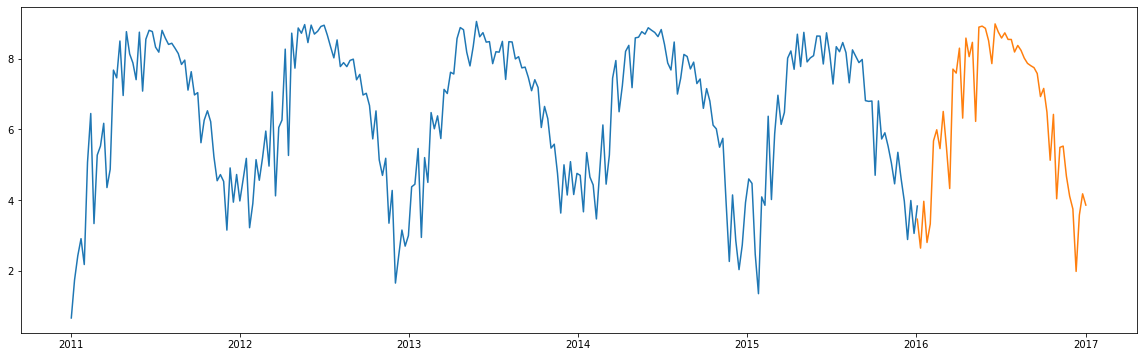

In [388]:
plt.figure(figsize=(20,6))
# plt.plot(data_train1[data_train1.index.year==2015]);
plt.plot(data_train1)
plt.plot(data_test1);

### Decomposition

In [389]:
data_train1.shape

(262,)

In [390]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=data_train1, model='additive', freq=52) # what is freq supposed to be?
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

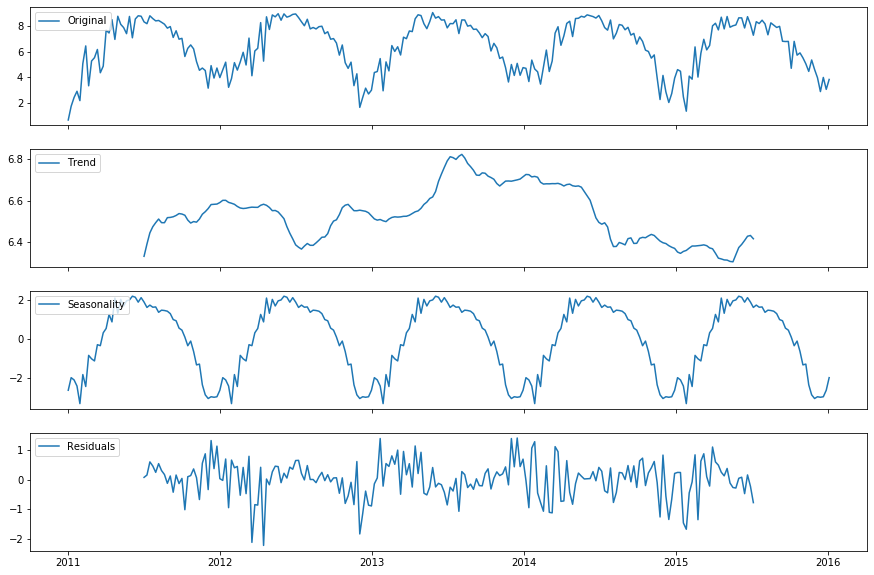

In [391]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data_train1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

### Stationarity testing

In [392]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_train1)
print(pvalue)

8.945380035372391e-08


In [393]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    plt.figure(figsize=(20,6))
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
#     plt.tight_layout()

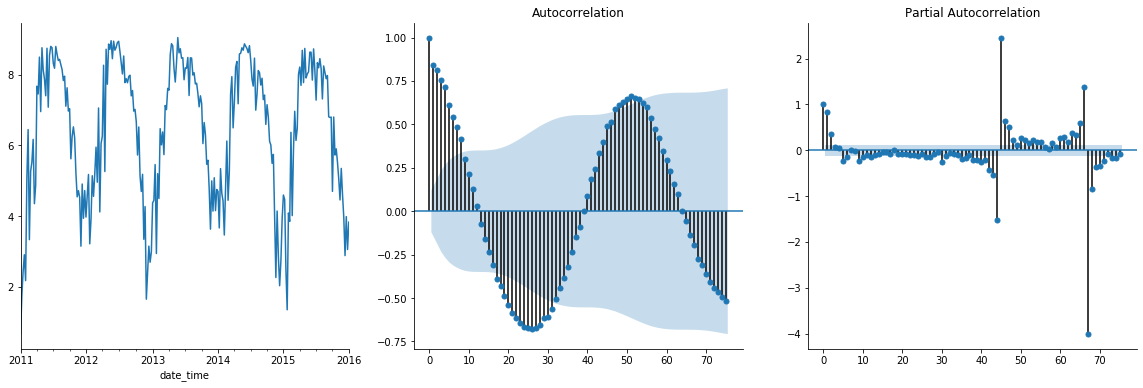

In [394]:
# helper plot for temps
plots(data_train1, lags=75);

### Add differencing - many lags of autocorrelation

In [395]:
# check daily deviations for various diffs
print(data_train1.std())
print(data_train1.diff().std()) # seems to be the best -difference once
print(data_train1.diff().diff().std())
print(data_train1.diff().diff().diff().std())

1.9662430011968992
1.0375623991648604
1.767551322529325
3.2602744419412373


In [396]:
data_train2 = data_train1.diff()[1:]

In [397]:
data_train2

date_time
2011-01-09    1.073660
2011-01-16    0.685170
2011-01-23    0.484222
2011-01-30   -0.731158
2011-02-06    2.888219
                ...   
2015-12-06   -0.644846
2015-12-13   -1.081770
2015-12-20    1.102827
2015-12-27   -0.930131
2016-01-03    0.773662
Freq: W-SUN, Name: kWh, Length: 261, dtype: float64

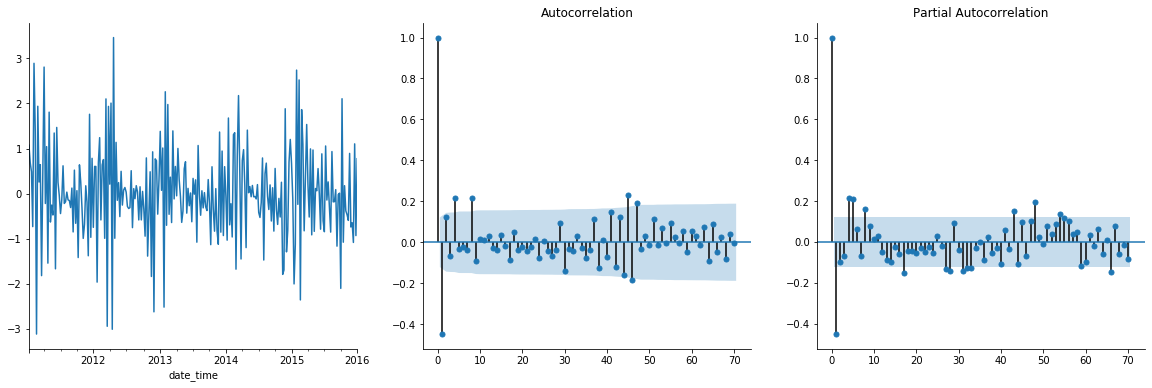

In [398]:
# helper plot for temps
plots(data_train2, lags=70);

In [399]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_train2)
print(pvalue)

0.0008495925862305298


after one order of differencing, there are around 10 significant PACF lags, so p = 10 (AR term)

### Add smoothing

### Model

In [451]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(data_train1,
                                order=(1, 1, 1),
                                seasonal_order=(0,1,0,52), 
                                trend='c').fit()
sar.summary()

# try with 8760 (24x365)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                kWh   No. Observations:                  262
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 52)   Log Likelihood                -317.394
Date:                            Tue, 03 Dec 2019   AIC                            642.787
Time:                                    15:03:41   BIC                            656.157
Sample:                                01-02-2011   HQIC                           648.193
                                     - 01-03-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0116      0.025     -0.473      0.636      -0.060       0.037
ar.L1         -0.1649      0.075     -2.210      0.027      -0.311      -0.019
ma.L1         -0.6868      0.069     -9.978      0.000      -0.822      -0.552
sigma2         1.2155      0.104     11.736      0.000       1.013       1.419
===================================================================================
Ljung-Box (Q):                       51.41   Jarque-Bera (JB):                 6.25
Prob(Q):                              0.11   Prob(JB):                         0.04
Heteroskedasticity (H):               0.88   Skew:                             0.02
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

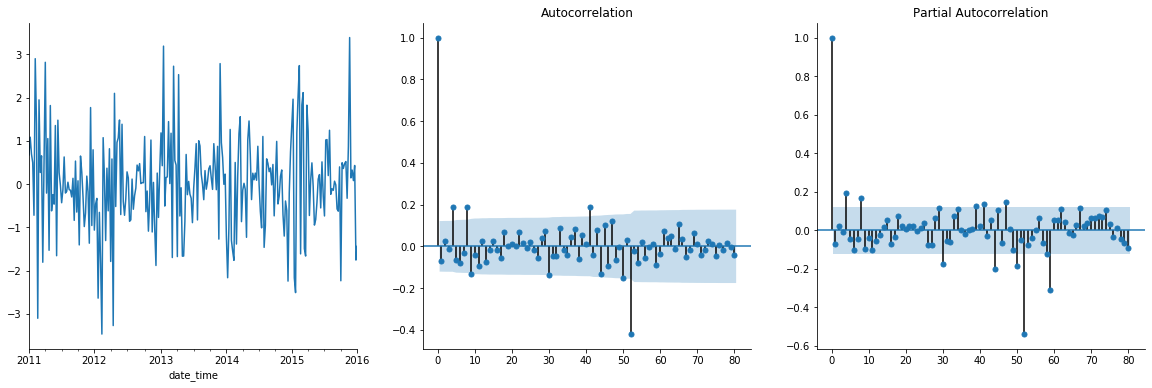

In [452]:
# plot resids
plots(sar.resid, lags=80);

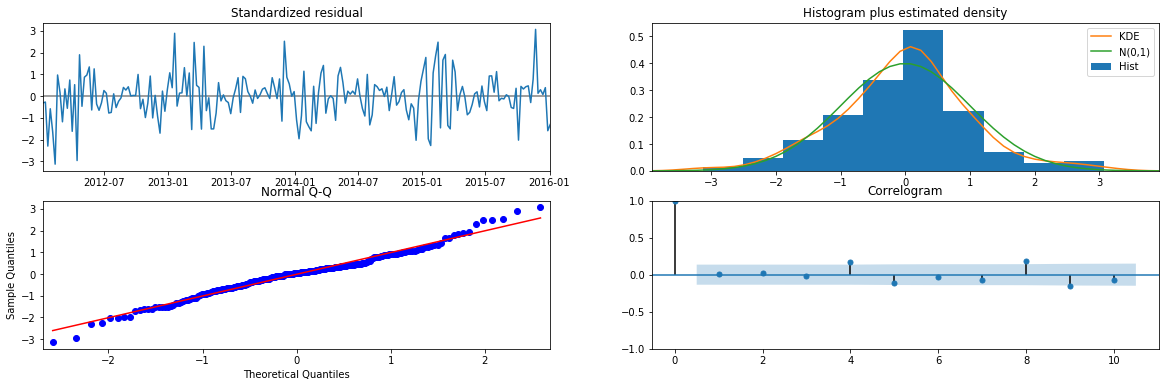

In [453]:
# plot residual diagnostics
sar.plot_diagnostics(figsize=(20,6));

In [454]:
y_pred = sar.predict(start=1,end=len(data_train1),dynamic=False)
# y_pred2 = sar.predict(start=len(data_train)+1,end=(len(data_train)+len(data_test)),dynamic=False)

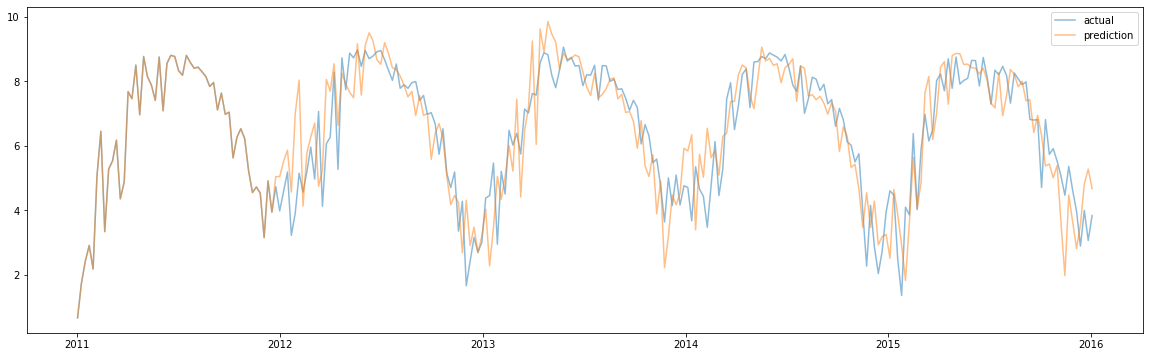

In [455]:
plt.figure(figsize=(20,6))
plt.plot(data_train1.index, data_train1.values,alpha=0.5,label='actual')
plt.plot(data_train1.index, y_pred.values,alpha=0.5,label='prediction')
plt.legend();

In [456]:
mse(data_train1.values,y_pred.values)

216.92441336278577

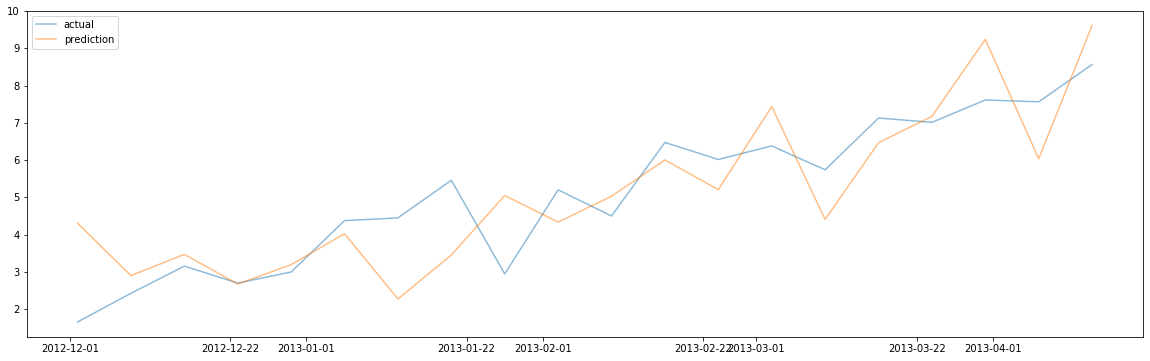

In [457]:
start = 100
end = 120
plt.figure(figsize=(20,6))
plt.plot(data_train1.index[start:end], data_train1.values[start:end],alpha=0.5,label='actual')
plt.plot(data_train1.index[start:end], y_pred.values[start:end],alpha=0.5,label='prediction')
plt.legend();

### forecast future

In [458]:
a = data_test1.shape[0]
data_for = sar.forecast(steps=a)
print(data_for.shape)
print(data_train1.shape)

(53,)
(262,)


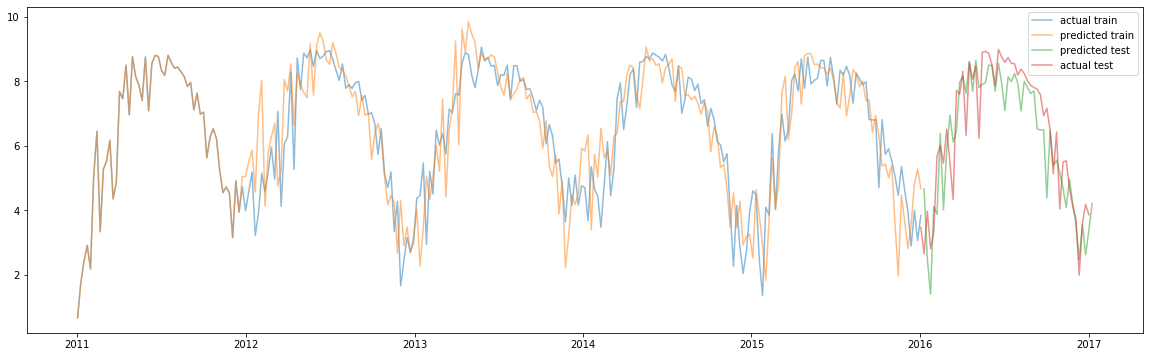

In [462]:
plt.figure(figsize=(20,6))
plt.plot(data_train1.index, data_train1.values,alpha=0.5,label='actual train')
plt.plot(data_train1.index, y_pred.values,alpha=0.5,label='predicted train')
plt.plot(data_for.index,data_for,alpha=0.5,label='predicted test')
plt.plot(data_test1.index,data_test1.values,alpha=0.5,label='actual test')
plt.legend();

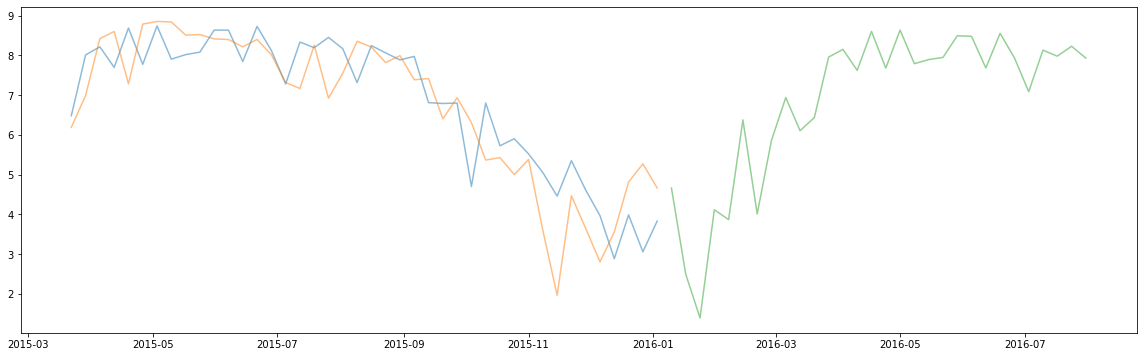

In [441]:
# start = 1040
# end = 1095
start = 220
end = 262
# end = len(data_train1)+len(data_test1)+1
plt.figure(figsize=(20,6))
plt.plot(data_train1.index[start:end], data_train1.values[start:end],alpha=0.5)
plt.plot(data_train1.index[start:end], y_pred.values[start:end],alpha=0.5)
plt.plot(data_for.index[0:30],data_for[0:30],alpha=0.5);